# Erstellen einer SVM auf dem MNIST Datensatz

## 1. Einlesen der Daten

Die benötigen Dateien wurden bereits heruntergeladen und müssen zunächst eingelesen werden.

In [1]:
import struct
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.preprocessing import scale
from sklearn.metrics import ConfusionMatrixDisplay
import joblib

# Enable Latex and increase fontsize in plots
plt.rcParams["text.usetex"] = True
plt.rcParams.update({"font.size": 22})

In [2]:
# Specify the paths where to find the image and label files
train_img_path = "./data/train-images-idx3-ubyte"
train_labels_path = "./data/train-labels-idx1-ubyte"
test_img_path = "./data/t10k-images-idx3-ubyte"
test_labels_path = "./data/t10k-labels-idx1-ubyte"

In [3]:
def read_labels(labels_path):
    # Read the labels. Option "rb" for reading bytes.
    with open(labels_path, "rb") as labels_file:
        # Unpacking is necessary to get rid of the first values that describe the data.
        _, num_labels = struct.unpack(">II", labels_file.read(8))
        print(f"{num_labels} labels loaded.")
        # The rest is saved as labels.
        labels = np.fromfile(labels_file, dtype=np.uint8)
    return labels

In [4]:
def read_images(img_path):
    # Read the training images.
    with open(img_path, "rb") as img_file:
        # Unpacking is necessary again and also gives information about the data.
        _, num_img, rows, cols = struct.unpack(">IIII", img_file.read(16))
        print(f"{num_img} images loaded.")
        print(f"Each image consists of {rows} rows and {cols} columns.")
        # The rest contains the image data. Reshape them into a <num_img>x<rows*cols>
        # matrix, where each row contains one image as one line.
        images = np.fromfile(img_file, dtype=np.uint8).reshape(num_img, rows*cols)
    return images

In [5]:
y_train = read_labels(train_labels_path)
y_test = read_labels(test_labels_path)
x_train = read_images(train_img_path)
x_test = read_images(test_img_path)
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Original data needed later for plotting.
x_test_backup = np.copy(x_test)

60000 labels loaded.
10000 labels loaded.
60000 images loaded.
Each image consists of 28 rows and 28 columns.
10000 images loaded.
Each image consists of 28 rows and 28 columns.
x_train shape: (60000, 784)
y_train shape: (60000,)


Die Daten wurden erfolreich eingelesen. Die Bilder liegen direkt als Vektoren vor, weshalb x_train die Form (60000,784) besitzt.

## 2. Verstehen der Daten

Zunächst betrachten wir eine einzelne Zahl. Die Pixelwerte liegen zwischen 0 und 255 und werden später noch normalisiert. 

In [6]:
print(x_train[1].reshape(28, 28), sep="")

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  51 159 253
  159  50   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  48 238 252 252
  252 237   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  54 227 253 252 239
  233 252  57   6   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  10  60 224 252 253 252 202
   84 252 253 122   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 163 252 252 252 25

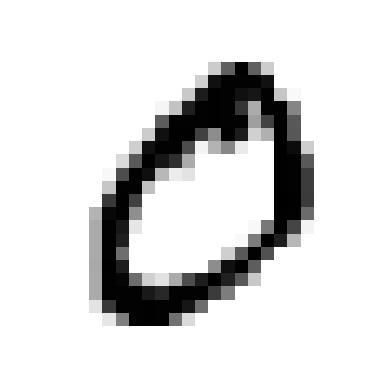

In [7]:
plt.axis("off")
# Reshape the 784 long feature vector and map it to a gray scale
plt.imshow(x_train[1].reshape(28, 28), cmap="gray_r", vmin=0, vmax=255)
plt.savefig("images/example_0.png")

Um eine noch bessere Übersicht über die Bilder der verschiedenen Ziffern zu bekommen, werden mehrere Bilder von jeder Ziffer erzeugt und in einem großen Bild zusammengefügt.

In [8]:
# Save the "row_images for every number"
final_images = []
# Search examples for every number
for i in range(10):
    examples_for_i = 0
    # Save images before merging them into one
    example_img_i = []
    for j in range(len(x_train)):
        # Stop searching when 30 images for the sought after number were found
        if examples_for_i >= 30:
            continue
        # Number matches the label we are looking for at the moment
        if y_train[j] == i:
            examples_for_i += 1
            example_img_i.append(x_train[j].reshape(28,28))
    # Merge all images into a big "row image" by concatenating horizontally
    all_i_one_image = np.hstack(example_img_i)
    final_images.append(all_i_one_image)

# Merge all row images into one big final image by concatenatig vertically
final_image = np.vstack(final_images)

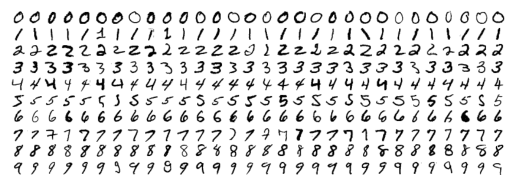

In [9]:
plt.axis("off")
plt.imshow(final_image, cmap="gray_r", vmin=0, vmax=255)
plt.savefig("images/multiple_examples.png", dpi=400)

Nun haben wir eine gute Übersicht über die Beschaffenheit der einzelnen Ziffern. Es fehlt noch eine Analyse, wie häufig jede Ziffer vertreten ist. Das ist eine wichtige Information, da nicht balancierte Probleme häufig weitere Challenges mit sich bringen und leichter zum Overfitting neigen.

In [10]:
def count_classes(y):
    # Counts how often each class is represented in the datasat.
    unique_values, counts = np.unique(y, return_counts=True)
    # Calculate percentages
    counts = counts / len(y) * 100
    # Confirm that the order of the numbers is correct and does not need to be rearranged.
    print(f"Check if the values are in order: {unique_values}")
    return counts

In [11]:
def barplot_class_representation(counts, title_part, output_filename):
    # Add x labels for every number
    x = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

    # Plot the data using a nicer colormap.
    cmap = plt.get_cmap("coolwarm")
    plt.bar(x, counts, color=cmap(np.linspace(0, 1, len(counts))))

    # Plot formatting
    #plt.title(f"Klassenverteilung im MNIST {title_part}datensatz")
    plt.xlabel("Ziffer")
    plt.ylabel("Relative Häufigkeit in \%")

    plt.savefig(output_filename)

Check if the values are in order: [0 1 2 3 4 5 6 7 8 9]


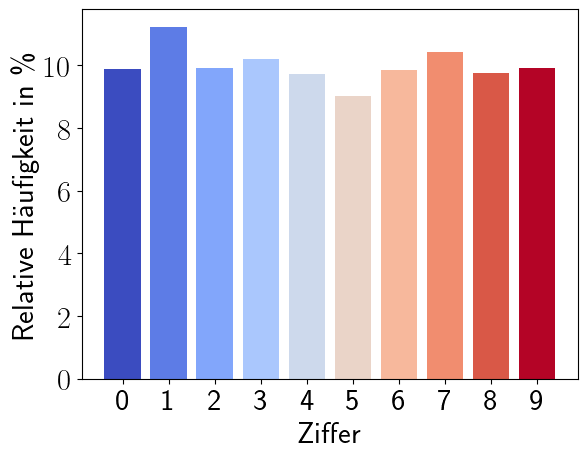

In [12]:
counts = count_classes(y_train)
barplot_class_representation(counts, "Trainings", "images/klassenverteilung_training.png")

Check if the values are in order: [0 1 2 3 4 5 6 7 8 9]


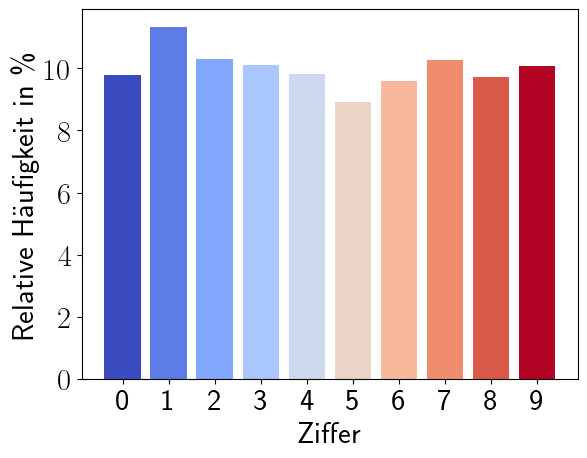

In [13]:
counts = count_classes(y_test)
barplot_class_representation(counts, "Test", "images/klassenverteilung_test.png")

## 3. Vorverarbeitung der Daten

Das Vorverarbeiten der Daten ist schnell erledigt. Für das korrekte Verhalten kann es allerdings entscheidenen sein, wie auch in der Dokumentation von scikit-learn erklärt wird: https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler

In [14]:
x_train = x_train / 255.0
x_test = x_test / 255.0
x_train = scale(x_train)
x_test = scale(x_test)

## 4. Welche Kernel-Funktion ist die beste?

Als nächstes wird evaluiert, welche der Kernel-Funktionen die beste für das vorliegende Problem sein könnte. Dafür werden zunächst die Grundeinstellungen von scikit-learn für jede Kernel-Funktion verwendet. Die Funktion mit dem besten Ergebnis wird anschließend in ausführlicheren Versuchen getestet.

Um die Rechenzeit zu verringern, wird der Trainingsdatensatz auf 10% der Gesamtgröße eingeschränkt unter der Annahme, dass sich abzeichnende Trends auf dem kleineren Teil auch für den größeren Teil des Datensatzes anwendbar sind.

In [15]:
x_train_tmp, x_test_tmp, y_train_tmp, y_test_tmp = train_test_split(x_train, y_train, test_size=0.5, train_size=0.1, random_state=0)

In [16]:
def train_simple_svm(kernel):
    # Train the classifier with the given kernel function
    clf = svm.SVC(kernel=kernel)
    clf.fit(x_train_tmp, y_train_tmp)

    # Calculate the accuracy based on the correctly predicted classes
    accuracy = clf.score(x_test_tmp, y_test_tmp)

    return accuracy

In [17]:
for kernel in ["linear", "rbf", "poly", "sigmoid"]:
    accuracy = train_simple_svm(kernel)
    print(f"The accuracy for the {kernel} kernel was: {accuracy}")

The accuracy for the linear kernel was: 0.9052
The accuracy for the rbf kernel was: 0.9269333333333334
The accuracy for the poly kernel was: 0.8747333333333334
The accuracy for the sigmoid kernel was: 0.8997


Anhand der Genauigkeit ist erkennbar, dass die RBF Kernel-Funktion am besten abschneidet. Der RBF Kernel scheint das Problem also am besten in einen höherdimensionalen Raum zu übersetzen, sodass die Daten besser durch eine Hyperebene separierbar sind. In den folgenden Versuchen wird daher der RBF Kernel genauer analysiert, um weitere Verbesserungen in der Genauigkeit zu erzielen.

Eine kleine Verbesserung wird durch das Ausbalancieren der Klassen ermöglicht. Dabei werden die Klassen so gewichtet, dass sie entgegen ihrer Frequenz gewichtet werden. Kommt eine Klasse als häufiger vor, so wird diese weniger stark gewichtet.

In [18]:
# Use the "balanced" parameter to simulate an exactly matching size of all classes.
clf = svm.SVC(kernel="rbf", class_weight="balanced")
clf.fit(x_train_tmp, y_train_tmp)
accuracy = clf.score(x_test_tmp, y_test_tmp)
print(f"The accuracy with balanced classes was: {accuracy}")

The accuracy with balanced classes was: 0.9271666666666667


## 5. Finden der besten Hyperparameter mittels GridSearch

Der RBF Kernel hat den anpassbaren Parameter gamma und dazu kann auch der Parameter C angepasst werden, welcher die Gewichtung der Strafterme bestimmt. Für beide Werte werden sinnvolle Werte geschätzt, dann wird mittels GridSearch die beste Kombination der Parameter gesucht.

Die beiden Parameter sollten dabei exponentiell steigen, um einen möglichst großen Bereich abzudecken und die bestmögliche Wahl treffen zu können. Siehe auch hier:
https://scikit-learn.org/stable/modules/svm.html#parameters-of-the-rbf-kernel

In [19]:
parameters = {
    "C" : [0.01, 0.1, 1, 10, 100, 1000, 10000],
    "gamma" : [10, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
}

# Die beste Kombination wird anhand der Genauigkeit ermittelt. Mit n_jobs = -1 wird so gut es geht parallelisiert und die CPU wird ganz ausgelastet.
clf = GridSearchCV(svm.SVC(kernel="rbf", class_weight="balanced"), parameters, scoring="accuracy", n_jobs=-1)
clf.fit(x_train_tmp, y_train_tmp)

GridSearchCV(estimator=SVC(class_weight='balanced'), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000, 10000],
                         'gamma': [10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05]},
             scoring='accuracy')

In [20]:
# Betrachten der Ergebnisse für alle Kombinationen. Entscheidend ist "mean_test_score". Dieser Wert gibt an, wie gut die Genauigkeit war. "params" enthält die
# entsprechende Kombination der Hyperparameter.
params = clf.cv_results_["params"]
mean_test_scores = clf.cv_results_["mean_test_score"]
print(params)
print(mean_test_scores)

[{'C': 0.01, 'gamma': 10}, {'C': 0.01, 'gamma': 1}, {'C': 0.01, 'gamma': 0.1}, {'C': 0.01, 'gamma': 0.01}, {'C': 0.01, 'gamma': 0.001}, {'C': 0.01, 'gamma': 0.0001}, {'C': 0.01, 'gamma': 1e-05}, {'C': 0.1, 'gamma': 10}, {'C': 0.1, 'gamma': 1}, {'C': 0.1, 'gamma': 0.1}, {'C': 0.1, 'gamma': 0.01}, {'C': 0.1, 'gamma': 0.001}, {'C': 0.1, 'gamma': 0.0001}, {'C': 0.1, 'gamma': 1e-05}, {'C': 1, 'gamma': 10}, {'C': 1, 'gamma': 1}, {'C': 1, 'gamma': 0.1}, {'C': 1, 'gamma': 0.01}, {'C': 1, 'gamma': 0.001}, {'C': 1, 'gamma': 0.0001}, {'C': 1, 'gamma': 1e-05}, {'C': 10, 'gamma': 10}, {'C': 10, 'gamma': 1}, {'C': 10, 'gamma': 0.1}, {'C': 10, 'gamma': 0.01}, {'C': 10, 'gamma': 0.001}, {'C': 10, 'gamma': 0.0001}, {'C': 10, 'gamma': 1e-05}, {'C': 100, 'gamma': 10}, {'C': 100, 'gamma': 1}, {'C': 100, 'gamma': 0.1}, {'C': 100, 'gamma': 0.01}, {'C': 100, 'gamma': 0.001}, {'C': 100, 'gamma': 0.0001}, {'C': 100, 'gamma': 1e-05}, {'C': 1000, 'gamma': 10}, {'C': 1000, 'gamma': 1}, {'C': 1000, 'gamma': 0.1}, 

In [21]:
# Ausgabe der besten Hyperparameter und dem dazugehörigen Genauigkeitsscore.
print(clf.best_estimator_)
print(clf.best_score_)

SVC(C=10, class_weight='balanced', gamma=0.001)
0.9373333333333334


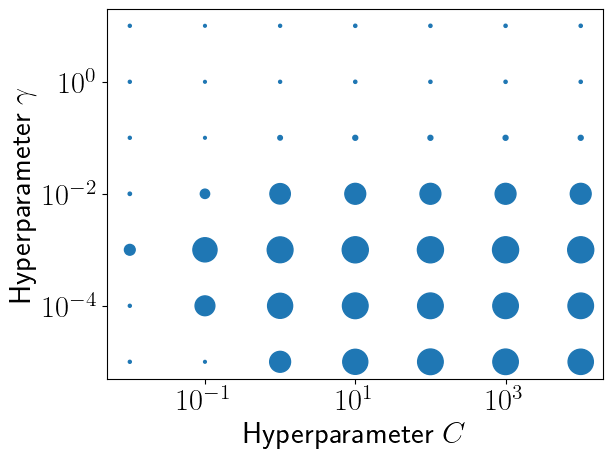

In [22]:
# Extract the values from the results and prepare the different sizes by multiplication.
C_values = [tmp["C"] for tmp in params]
gamma_values = [tmp["gamma"] for tmp in params]
sizes = (mean_test_scores*20)**2

fig = plt.figure()
ax = plt.gca()
ax.scatter(C_values, gamma_values, s=sizes)
ax.set_xscale("log")
ax.set_yscale("log")
plt.xlabel(r"Hyperparameter $C$")
plt.ylabel(r"Hyperparameter $\gamma$")
plt.savefig("images/gridsearch.png")

Die beste Kombination an Hyperparametern ist $C=10$ und $\gamma=0.001$. Dies liegt mittig in dem getesteten Bereich und umliegende Kombinationen scheinen keine große Änderung zu ergeben, daher lohnt sich eine tiefergehende Suche zwischen den bisher getesteten Parametern nicht. Die gefundenen besten Hyperparameter werden von nun an verwendet. 

## 6. $k$-fold Cross-Validation

Da die Hyperparameter nun festgelegt sind, soll nun der gesamte Datensatz verwendet werden. Dazu wird versucht $k$-fold Cross-Validation anzuwenden um nicht nur den Trainingsdatensatz, sondern alle 70,000 Datenpunkten (60,000 Trainingsdatenpunkte + 10,000 Testdatenpunkte) für das Training zu nutzen, um die Genauigkeit weiterhin zu verbessern.

In [23]:
# Use the previously determined hyperparameters C and gamma
clf = svm.SVC(kernel="rbf", class_weight="balanced", C=10, gamma=0.001)
clf.fit(x_train, y_train)
accuracy = clf.score(x_test, y_test)
print(f"The accuracy was: {accuracy}")

The accuracy was: 0.9723


In [24]:
# Create a big dataset with all available datapoints to try out cross-validation.
x_train_tmp = np.vstack((x_train, x_test))
y_train_tmp = np.concatenate((y_train, y_test))

Teste nacheinander mit $k=3,5,7,10$. Eine weitere Steigerung von $k$ lohnt sich nicht mehr, da der Validationsdatensatz dann zu klein wird.

In [25]:
def svm_cross_validation(folds):
    clf = svm.SVC(kernel="rbf", class_weight="balanced", C=10, gamma=0.001)
    # Use the given number of folds. Set n_jobs=-1 in order to use all cpu cores and speed up the training process.
    scores = cross_val_score(clf, x_train_tmp, y_train_tmp, cv=folds, n_jobs=-1)
    print(f"The model achieved a mean accuracy of {scores.mean()}%.")

In [26]:
svm_cross_validation(3)

The model achieved a mean accuracy of 0.9695000001916299%.


In [27]:
svm_cross_validation(5)

The model achieved a mean accuracy of 0.9713571428571429%.


In [28]:
svm_cross_validation(7)

The model achieved a mean accuracy of 0.9721428571428571%.


In [29]:
svm_cross_validation(10)

The model achieved a mean accuracy of 0.9726857142857144%.


Die Ergebnisse dieser Versuche waren:

$k=3$: 96,95%

$k=5$: 97,136%

$k=7$: 97,214%

$k=10$: 97,269%

## 7. One-vs-one oder One-vs-rest?

Zu guter letzt wird noch getestet, ob sich die Anwendung von dem One-vs-one- oder dem One-vs-Rest-Klassifikator mehr lohnt. Dazu werden alle zuvor ermittelten Einstellungen übernommen.

In [30]:
clf = OneVsOneClassifier(svm.SVC(kernel="rbf", class_weight="balanced", C=10, gamma=0.001), n_jobs=-1)
clf.fit(x_train, y_train)
accuracy = clf.score(x_test, y_test)
print(f"The accuracy was: {accuracy}")

The accuracy was: 0.9724


In [31]:
clf = OneVsRestClassifier(svm.SVC(kernel="rbf", class_weight="balanced", C=10, gamma=0.001), n_jobs=-1)
clf.fit(x_train, y_train)
accuracy = clf.score(x_test, y_test)
print(f"The accuracy was: {accuracy}")

The accuracy was: 0.975


## 8. Das beste Modell abspeichern

Nun wurde das beste Modell gefunden und wir abgespeichert, damit es nicht erneut trainiert werden muss, sondern direkt zur Vorhersage genutzt werden kann.

In [32]:
joblib.dump(clf, "best_modell.joblib")

['best_modell.joblib']

In [33]:
clf = joblib.load("best_modell.joblib")

## 9. Konfusionsmatrix aufstellen

Nun wird eine Konfusionsmatrix aufgestellt, um sehen zu können, wie viele Bilder richtig klassifiziert wurden und zu welchem Anteil jede Klasse richtig vorhergesagt wurde. Man kann auch schon erkennen, welche Ziffern schwieriger vorherzusagen waren und bei welchen es besser geklappt hat.

In [34]:
# Predict the classes for the test set with the loaded model.
predictions = clf.predict(x_test)

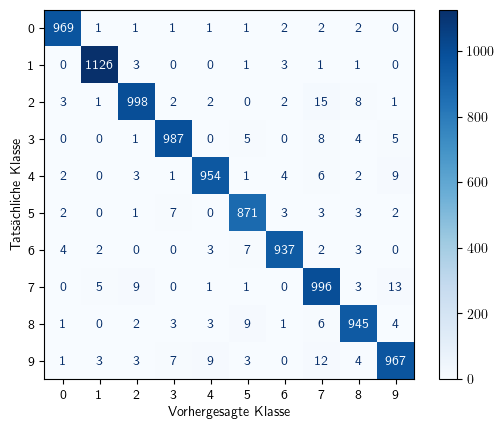

In [45]:
# Decrease fontsize for these plots again
plt.rcParams.update({"font.size": 10})
# Specify label namens
class_names = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
# Calculate the confusion matrix with the given true and predicated labels.
disp = ConfusionMatrixDisplay.from_predictions(y_true=y_test,
                                               y_pred=predictions,
                                               display_labels=class_names,
                                               cmap=plt.cm.Blues)
disp.ax_.set_xlabel("Vorhergesagte Klasse")
disp.ax_.set_ylabel("Tatsächliche Klasse")
disp.figure_.savefig("images/konfusionsmatrix.png")

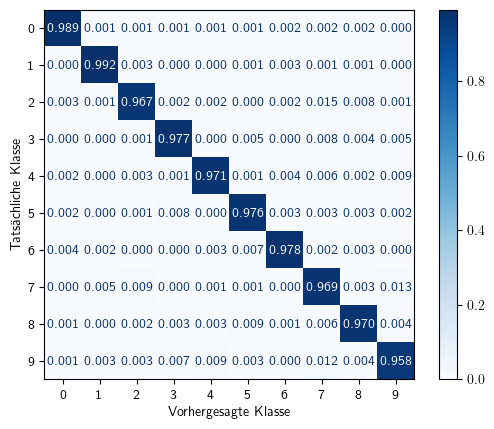

In [46]:
class_names = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
disp = ConfusionMatrixDisplay.from_predictions(y_true=y_test,
                                               y_pred=predictions,
                                               display_labels=class_names,
                                               cmap=plt.cm.Blues,
                                               normalize="true",
                                               values_format=".3f")
disp.ax_.set_xlabel("Vorhergesagte Klasse")
disp.ax_.set_ylabel("Tatsächliche Klasse")
disp.figure_.savefig("images/konfusionsmatrix_normalisiert.png")

## 10. Falsch vorhergesagte Bilder betrachten

Nun werden noch alle falsch vorhergesagten Bilder in einem großen Bild zusammengefasst. Es ist deutlich erkennbar, dass es sich um schwierige Fälle handelt. Im Vergleich zu der Ausgabe weiter oben, sind die Ziffern auch für das menschliche Auge deutlich schlechter erkennbar und manche "siebenen" sind aus meiner Sicht sogar im Datensatz falsch klassifiziert.

In [37]:
# Create a dict that saves all wrong images in a list, sorted by number
wrong = {0: [], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}
for i, prediction in enumerate(predictions):
     # A wrong prediction was found, because the true label (y_test) was different than the predicted label.
     if prediction != y_test[i]:
          wrong[y_test[i]].append(x_test_backup[i].reshape(28,28))

In [38]:
# The number of total images with a wrong classification
sum([len(img_list) for img_list in wrong.values()])

250

In [39]:
# The number of wrongly classified images for the class with the most errors (number 9).
max_length = max([len(img_list) for img_list in wrong.values()])

In [40]:
# Similar to before. Build row images and stack them together in the end to create a full image with all wrong classified images.
row_images = []
for img_list in wrong.values():
    # Stack all images of one of the lists created before side by side to create a row image.
    tmp_row_img = np.hstack(img_list)
    # Image will be too short if other classes have more wrongly classified images. Fill with zeros (empty image) in this case.
    if tmp_row_img.shape[1] < 28*max_length:
        zero_fill_img = np.zeros((28, 28*max_length-tmp_row_img.shape[1]))
        tmp_row_img = np.hstack((tmp_row_img, zero_fill_img))
    row_images.append(tmp_row_img)

# Create a final image by stacking the row images on top of each other.
final_image = np.vstack(row_images)

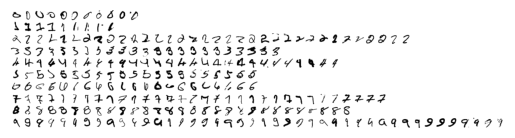

In [41]:
plt.axis("off")
plt.imshow(final_image, cmap="gray_r", vmin=0, vmax=255)
plt.savefig("images/wrong_classification_images.png", dpi=400)